# Tabulate rho(P,T) using Van der Waals equation of state
This notebook is based on code originally written by Claire Guimond

In [5]:
import numpy as np
from numpy.polynomial import Polynomial
from thermotools.plot import *
from thermotools import moles
from thermotools import phase
from matplotlib.ticker import MultipleLocator

Define constants

In [112]:
Rgas = 8.31446261815324

# Van Der Waals coefficients
#    From Wikipedia data page.
#    https://en.wikipedia.org/wiki/Van_der_Waals_constants_(data_page)
#    Units: bars, moles/litre
vdw = {
    "NH3"    : (4.225   ,  0.0371),
    "Ar"     : (1.355   ,  0.03201),
    "C4H10"  : (14.66   ,  0.1226),
    "CO2"    : (3.640   ,  0.04267),
    "CS2"    : (11.77   ,  0.07685),
    "CO"     : (1.505   ,  0.0398500),
    "CCl4"   : (19.7483 ,  0.1281),
    "Cl"     : (6.579   ,  0.05622),
    "C2N2"   : (7.769   ,  0.06901),
    "C4H10O" : (17.61   ,  0.1344),
    "CH3SCH3": (13.04   ,  0.09213),
    "C2H6"   : (5.562   ,  0.0638),
    "C2H5OH" : (12.18   ,  0.08407),
    "Fl"     : (1.171   ,  0.0290),
    "He"     : (0.0346  ,  0.0238),
    "N2H4"   : (8.46    ,  0.0462),
    "H2"     : (0.2476  ,  0.02661),
    "HBr"    : (4.510   ,  0.04431),
    "HCl"    : (3.716   ,  0.04081),
    "HCN"    : (11.29   ,  0.0881),
    "HF"     : (9.565   ,  0.0739),
    "HI"     : (6.309   ,  0.0530),
    "H2Se"   : (5.338   ,  0.04637),
    "H2S"    : (4.490   ,  0.04287),
    "C4H10"  : (13.32   ,  0.1164),
    "Kr"     : (2.349   ,  0.03978),
    "Kg"     : (8.200   ,  0.01696),
    "CH4"    : (2.253   ,  0.04278),
    "CH4O"   : (9.649   ,  0.06702),
    "Ne"     : (0.2135  ,  0.01709),
    "NO"     : (1.358   ,  0.02789),
    "N2"     : (1.370   ,  0.0387),
    "NO2"    : (5.354   ,  0.04424),
    "NF3"    : (3.58    ,  0.0545),
    "N2O"    : (3.832   ,  0.04415),
    "O2"     : (1.382   ,  0.03186),
    "O3"     : (3.570   ,  0.0487),
    "PH3"    : (4.692   ,  0.05156),
    "SiH4"   : (4.377   ,  0.05786),
    "SO2"    : (6.803   ,  0.05636),
    "SF6"    : (7.857   ,  0.0879),
    "CCl4"   : (20.01   ,  0.1281),
    "H2O"    : (5.536   ,  0.03049),
    "Xe"     : (4.250   ,  0.05105),
} 

# function to convert coefficients to SI
def coeff_SI(a, b):
    # Convert coefficients to SI
    a_SI = a / 1.e6 * 1.e5  # m^6.Pa.mol^-2
    b_SI = b / 1.e3  # m^3.mol^-1
    return a_SI, b_SI

# convert all of the coefficients to SI
for k in vdw.keys():
    a_SI, b_SI = coeff_SI(vdw[k][0], vdw[k][1])
    vdw[k] = (a_SI, b_SI)

In [113]:
mmw_table = moles.read_elements()


In [114]:
p_eval = np.logspace(0,   10,   100)  # Pa
T_eval = np.arange(  10,  5000, 20)  # K

print("Num points = %g"%(len(p_eval)*len(T_eval),))

Num points = 25000


In [115]:
def rho_ideal(M, p, T):
    # SI units
    # ideal gas density in kg/m3
    return p * M / (8.314 * T)

def calc_critical_point(a, b):
    # SI units
    # https://www.thermopedia.com/content/1232/
    Tc = 8*a / (27*Rgas*b)
    pc = a / (27*b**2)
    return pc, Tc

647.0393523234393


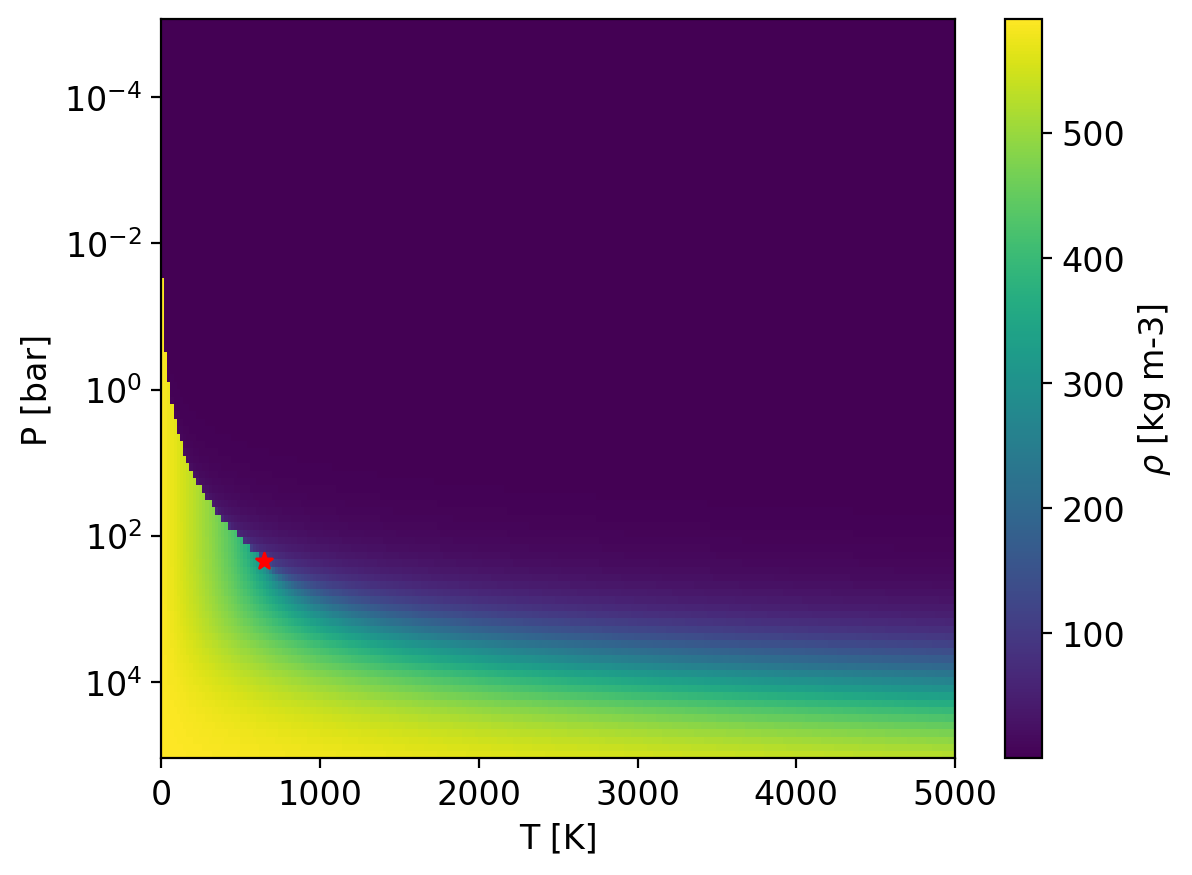

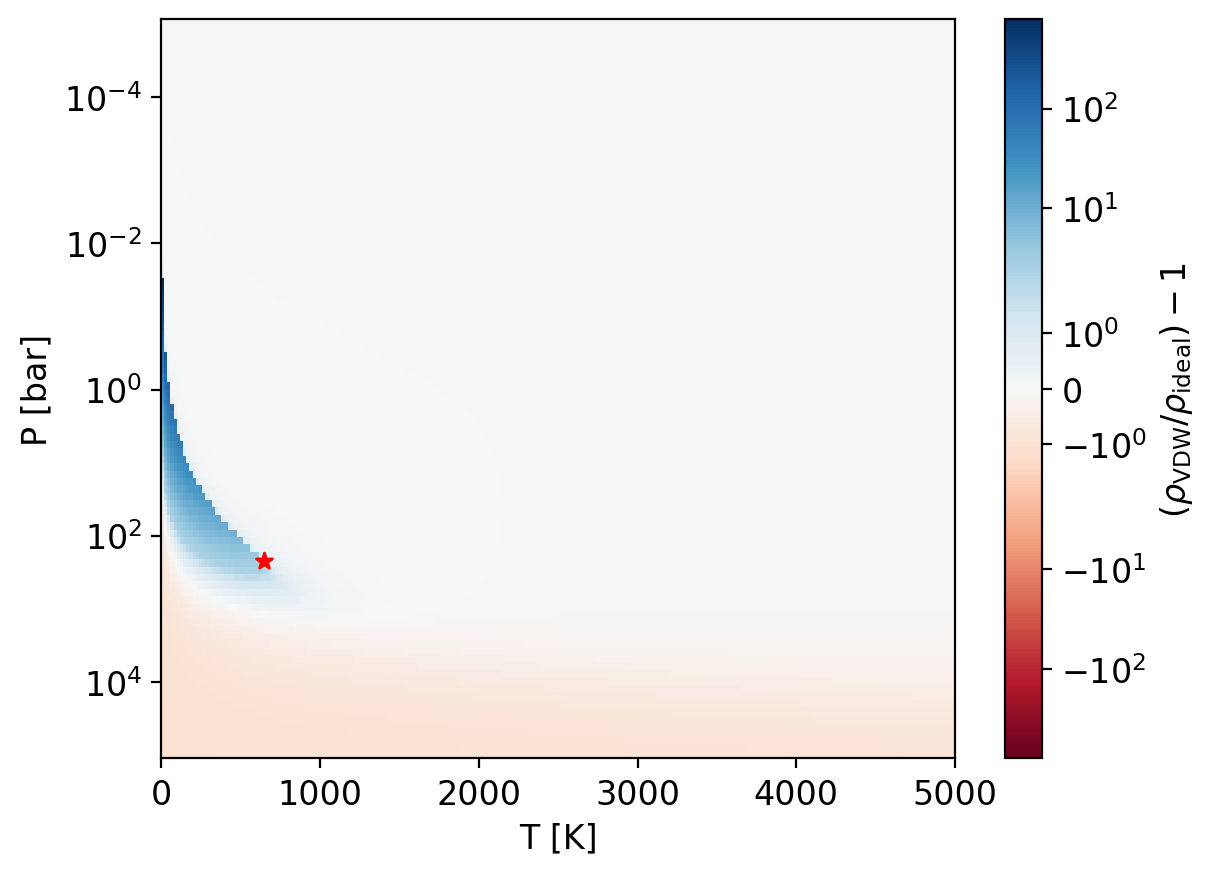

In [118]:
def rho_VDW(a, b, M, T, p):
    """
    input a, b in SI units, T in K, p in Pa, M in kg/mol
    https://scipython.com/book/chapter-6-numpy/problems/p64/the-van-der-waals-equation-of-state/
    """
    from numpy.polynomial import Polynomial

    pc, Tc = calc_critical_point(a, b)

    def get_poly(a_SI, b_SI, T, p):
        return Polynomial([-a_SI * b_SI, a_SI, -(p * b_SI + Rgas * T), p])

    poly = get_poly(a, b, T, p)
    roots = poly.roots()
    roots.sort()
    n_real_roots = len(roots[roots.imag == 0])

    if n_real_roots == 1:
        Vgas = roots[roots.imag == 0][0].real  # in m3/mol
        return M  / Vgas
    
    elif n_real_roots == 3:
        # If below the critical point, we expect three roots, from which we want the smallest and largest:
        assert (T < Tc) or (p < pc)
        Vliq, Vgas = roots[0], roots[-1]  # in m3/mol
        return M / Vgas  # kg/m3

    else:
        raise NotImplementedError

def plot_phasespace(a, b, M):

    pc, Tc = calc_critical_point(a, b)
    print(Tc)

    fig1, ax1 = plt.subplots(1, 1)
    fig2, ax2 = plt.subplots(1, 1)

    for ax in (ax1, ax2):
        ax.invert_yaxis()
        ax.set_yscale('log')
        ax.set_xlabel('p')
        ax.set_ylabel('T')
        ax.set_xlabel('T [K]')
        ax.set_ylabel('P [bar]')
        ax.scatter(Tc, pc * 1e-5, marker='*', zorder=100, c='r')  # critical point

    P, T = np.meshgrid(p_eval, T_eval)
    rhov = np.zeros_like(P)
    rho_ratio = np.zeros_like(P)
    for ii in range(len(p_eval)):
        for jj in range(len(T_eval)):
            rhov[jj, ii] = rho_VDW(a, b, M, T[jj, ii], P[jj, ii])
            rho_ratio[jj, ii] = rhov[jj, ii] / rho_ideal(M, P[jj, ii], T[jj, ii]) - 1

    im1 = ax1.pcolor(T, P * 1e-5, rhov, cmap='viridis')
    fig1.colorbar(im1, label=r'$\rho$ [kg m-3]')

    vmax = np.amax(rho_ratio)
    im2 = ax2.pcolor(T, P * 1e-5, rho_ratio, cmap='RdBu', norm='symlog', vmin=-1*vmax, vmax=vmax)
    fig2.colorbar(im2, label=r'$(\rho_{\rm VDW} / \rho_{\rm ideal}) - 1$')

    plt.show()


gas = "H2O"
plot_phasespace(vdw[gas][0], vdw[gas][1], moles.mmw_from_formula(gas, mmw_table))